### Read and merge data from different sources

In [177]:
import pandas as pd
df = pd.read_excel('../../data/interim/iva_kumulativ.xlsx')
df = df[df['Region'] != 'Hela riket']
befolkning = pd.read_excel('../../data/raw/befolkning.xlsx', skiprows=9)
befolkning = befolkning[['Hela riket', 10327589, 41.313715]]
befolkning.dropna(inplace=True)
befolkning.columns = ['Region', 'Befolkning', 'Medelålder']
befolkning = befolkning[befolkning['Region'] != 'Gotlands län']
befolkning.reset_index(inplace=True)
befolkning.drop('index', axis=1, inplace=True)

lan_to_region = {'Stockholms län': 'Region Stockholm', 'Södermanlands län': 'Region Sörmland', 
                 'Östergötlands län': 'Region Östergötland', 'Jönköpings län': 'Region Jönköpings län',
                 'Kronobergs län': 'Region Kronoberg', 'Kalmar län': 'Region Kalmar län',
                 'Blekinge län': 'Region Blekinge', 'Skåne län': 'Region Skåne',
                 'Hallands län': 'Region Halland', 'Västra Götalands län': 'Västra Götalandsregionen',
                 'Värmlands län': 'Region Värmland', 'Örebro län': 'Region Örebro län', 
                 'Västmanlands län': 'Region Västmanland', 'Dalarnas län': 'Region Dalarna',
                 'Gävleborgs län': 'Region Gävleborg', 'Västernorrlands län': 'Region Västernorrland',
                 'Jämtlands län': 'Region Jämtland Härjedalen', 'Västerbottens län': 'Region Västerbotten',
                 'Norrbottens län': 'Region Norrbotten', 'Uppsala län': 'Region Uppsala'
                }

befolkning['Region'] = [lan_to_region[val] for val in befolkning['Region']]
df = df.merge(befolkning, on='Region', how='inner')

### Read case data

In [180]:
from datetime import datetime


cases = pd.read_csv('../../data/folkhalsomyndigheten_covid19.csv')
cases.columns = [str(datetime.strptime(col, '%Y-%m-%d %H:%M:%S').date()) if col != 'Region' else col
                 for col in cases.columns
                ]
region_keys = {'Region Stockholm': 'Stockholm','Region Sörmland': 'Sörmland',  
                 'Region Östergötland': 'Östergötland', 'Region Jönköpings län': 'Jönköping',
                 'Region Kronoberg': 'Kronoberg','Region Kalmar län': 'Kalmar',
                 'Region Blekinge': 'Blekinge', 'Region Skåne': 'Skåne',
                 'Region Halland': 'Halland', 'Västra Götalandsregionen': 'Västra_Götaland',
                 'Region Värmland': 'Värmland', 'Region Örebro län': 'Örebro', 
                 'Region Västmanland': 'Västmanland', 'Region Dalarna': 'Dalarna',
                 'Region Gävleborg': 'Gävleborg', 'Region Västernorrland': 'Västernorrland',
                 'Region Jämtland Härjedalen': 'Jämtland_Härjedalen', 'Region Västerbotten': 'Västerbotten',
                 'Region Norrbotten': 'Norrbotten', 'Region Uppsala': 'Uppsala'
                }

### Functions for data prep

In [357]:

def get_cases_per_day_and_region(cases, region):
    # Change key name
    region = region_keys[region]
    
    tmp_df = cases[cases['Region'] == region]
    dates = pd.date_range('2020-03-06', '2020-03-31')
    dates = [str(date.date()) for date in dates]
    values = [tmp_df[date].iloc[0] for date in dates]
    values = [sum(values[:i]) for i in range(len(values))]
    tmp_df = pd.DataFrame({'date': dates, 'cases': values})
    tmp_df['Region'] = region
    return tmp_df



def create_dataframe_per_region(df, region, cases):
    tmp_df = df[df['Region'] == region]
    #tmp_df.drop(['2020-04-01', '2020-03-31', '2020-03-30', '2020-03-29'], axis=1, inplace=True)
    dates = tmp_df.drop(['Region', 'Befolkning', 'Medelålder'], axis=1).columns
    values = tmp_df.drop(['Region', 'Befolkning', 'Medelålder'], axis=1).iloc[0].values
    befolkning = tmp_df['Befolkning'].values[0]
    mean_age = tmp_df['Medelålder'].values[0]
    tmp_df = pd.DataFrame({'date': dates, 'iva': values})
    tmp_df['befolkning'] = befolkning 
    tmp_df['mean_age'] =  mean_age
    tmp_df['Region'] = region
    tmp_df = add_change_coming_x_days(tmp_df, 3)
    for i in range(1, 8):
        tmp_df = add_change_since_x_days_ago(tmp_df, i)
    #for i in range(1, 8):
     #   tmp_df = add_change_in_nbrs_since_x_days_ago(tmp_df, i)
        
    # Add data about cases
    cases_df = get_cases_per_day_and_region(cases, region)
    tmp_df = tmp_df.merge(cases_df.drop('Region', axis=1), on='date', how='left')
    #for i in range(7, 14):
     #   tmp_df = add_change_in_cases_since_x_days_ago(tmp_df, i)
    tmp_df = add_case_change_from_day_10_to_4(tmp_df)
    return tmp_df

def add_change_since_x_days_ago(df, x):
    change = []
    for i in range(len(df)):
        if i < x:
            change.append(None)
        else:
            change.append(df['iva'].iloc[i]/df['iva'].iloc[i-x])
    df['change_since_'+str(x)+'_days'] = change
    return df


def add_growth_factor_x_days_ago(df, x):
    change = []
    for i in range(len(df)):
        if i < x:
            change.append(None)
        else:
            change.append(df['iva'].iloc[i-x+1]/df['iva'].iloc[i-x])
    df['growth_'+str(x)+'_days_ago'] = change
    return df


def add_change_coming_x_days(df, x):
    change = []
    for i in range(len(df)):
        if len(df) - i - 1 < x:
            change.append(None)
        else:
            change.append(df['iva'].iloc[i+x]/df['iva'].iloc[i])
    df['change_coming_'+str(x)+'_days'] = change
    return df


def add_change_in_nbrs_since_x_days_ago(df, x):
    change = []
    for i in range(len(df)):
        if i < x:
            change.append(None)
        else:
            change.append(df['iva'].iloc[i] - df['iva'].iloc[i-x])
    df['change_in_nbrs_since_'+str(x)+'_days'] = change
    return df


def add_change_in_cases_since_x_days_ago(df, x):
    change = []
    for i in range(len(df)):
        if i < x:
            change.append(None)
        else:
            change.append(df['cases'].iloc[i]/df['cases'].iloc[i-x])
    df['cases_change_since_'+str(x)+'_days'] = change
    return df


def add_case_change_from_day_10_to_4(df):
    change = []
    for i in range(len(df)):
        if i < 10:
            change.append(None)
        else:
            change.append(df['cases'].iloc[i-4]/df['cases'].iloc[i-10])
    df['case_change_from_day_10_to_4'] = change
    return df




def add_case_growth_factor_x_days_ago(df, x):
    change = []
    for i in range(len(df)):
        if i < x:
            change.append(None)
        else:
            change.append(df['cases'].iloc[i-x+1]/df['cases'].iloc[i-x])
    df['case_growth_'+str(x)+'_days_ago'] = change
    return df

### Prep data

In [358]:
# Create dataframe with all regions

regions = list(df['Region'].unique())

for i, region in enumerate(regions):
    if i == 0:
        data = create_dataframe_per_region(df, region, cases)
        
    else:
        tmp_data = create_dataframe_per_region(df, region, cases)
        data = pd.concat([data, tmp_data])
        
data['iva_per_1000'] = data['iva']/data['befolkning']*1000
data
    

/home/fredrik/projects/hack-the-crisis/env/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars
/home/fredrik/projects/hack-the-crisis/env/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in double_scalars
/home/fredrik/projects/hack-the-crisis/env/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
/home/fredrik/projects/hack-the-crisis/env/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars
/home/fredrik/projects/hack-the-crisis/env/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars
/home/fredrik/projects/hack-the-crisis/env/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in double_scalars


,date,iva,befolkning,mean_age,Region,change_coming_3_days,change_since_1_days,change_since_2_days,change_since_3_days,change_since_4_days,change_since_5_days,change_since_6_days,change_since_7_days,cases,case_change_from_day_10_to_4,iva_per_1000
0,2020-03-06,NaN,159606.0,43.358574,Region Blekinge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,2020-03-07,NaN,159606.0,43.358574,Region Blekinge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,2020-03-08,0.0,159606.0,43.358574,Region Blekinge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.000000
3,2020-03-09,0.0,159606.0,43.358574,Region Blekinge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.000000
4,2020-03-10,0.0,159606.0,43.358574,Region Blekinge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,2020-03-28,49.0,1725881.0,41.079673,Västra Götalandsregionen,1.428571,1.113636,1.225000,1.484848,1.633333,1.884615,2.333333,2.722222,317.0,1.373626,0.028391
23,2020-03-29,60.0,1725881.0,41.079673,Västra Götalandsregionen,1.283333,1.224490,1.363636,1.500000,1.818182,2.000000,2.307692,2.857143,342.0,1.354167,0.034765
24,2020-03-30,65.0,1725881.0,41.079673,Västra Götalandsregionen,NaN,1.083333,1.326531,1.477273,1.625000,1.969697,2.166667,2.500000,357.0,1.354369,0.037662
25,2020-03-31,70.0,1725881.0,41.079673,Västra Götalandsregionen,NaN,1.076923,1.166667,1.428571,1.590909,1.750000,2.121212,2.333333,384.0,1.305677,0.040559


### Train model and predict

In [410]:
from sklearn.linear_model import LinearRegression
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

split_date = '2020-03-26'
train = data[data['date'] < split_date]
train = train.replace(np.inf, np.nan)
train = train.dropna()
test = data[(data['date'] >= split_date) & (data['date'] < '2020-03-30')]
X = train.drop(['date', 'change_coming_3_days', 'Region', 'cases'], axis=1)
y = train['change_coming_3_days']

param_grid = {'n_esimators': [30, 50, 100, 200, 300],
              'learning_rate': [0.01, 0.03, 0.05, 0.1],
              'max_depth': [3, 4, 5, 6, 7, 8]
             }

model = XGBRegressor(n_estimators=200, learning_rate=0.01, max_depth=4)
model.fit(X, y)
X_test = test.drop(['date', 'change_coming_3_days', 'Region', 'cases'], axis=1)
y_test = test['change_coming_3_days']
pred = model.predict(X_test)
test['predicted_change'] = pred
test['predicted_nbr_in_3_days'] = (test['iva']*test['predicted_change']).astype('int')
test['iva_in_3_days'] = test['iva']*test['change_coming_3_days']
test['absolute_error_%'] = abs(test['predicted_change']-test['change_coming_3_days'])/test['change_coming_3_days']
test['absolute_error_%'].mean()


/home/fredrik/projects/hack-the-crisis/env/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/fredrik/projects/hack-the-crisis/env/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/fredrik/projects/hack-the-crisis/env/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

0.1572999790406108

### Results

In [411]:
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime


results = test[['date', 'Region', 'predicted_nbr_in_3_days']]
results['date'] = [str(datetime.strptime(day, '%Y-%m-%d').date()+timedelta(days=3)) for day in results['date']]
results.columns = ['date', 'Region', 'predicted']

results = results.merge(data, on=['date', 'Region'], how='left')[['date', 'Region', 'predicted', 'iva']]
results['absolute_error_%'] = abs(results['predicted']-results['iva'])/results['iva']
results


/home/fredrik/projects/hack-the-crisis/env/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,date,Region,predicted,iva,absolute_error_%
0,2020-03-29,Region Blekinge,0,1.0,1.000000
1,2020-03-30,Region Blekinge,0,1.0,1.000000
2,2020-03-31,Region Blekinge,1,1.0,0.000000
3,2020-04-01,Region Blekinge,1,1.0,0.000000
4,2020-03-29,Region Dalarna,11,10.0,0.100000
...,...,...,...,...,...
75,2020-04-01,Region Östergötland,33,29.0,0.137931
76,2020-03-29,Västra Götalandsregionen,45,60.0,0.250000
77,2020-03-30,Västra Götalandsregionen,51,65.0,0.215385
78,2020-03-31,Västra Götalandsregionen,59,70.0,0.157143


### Plot

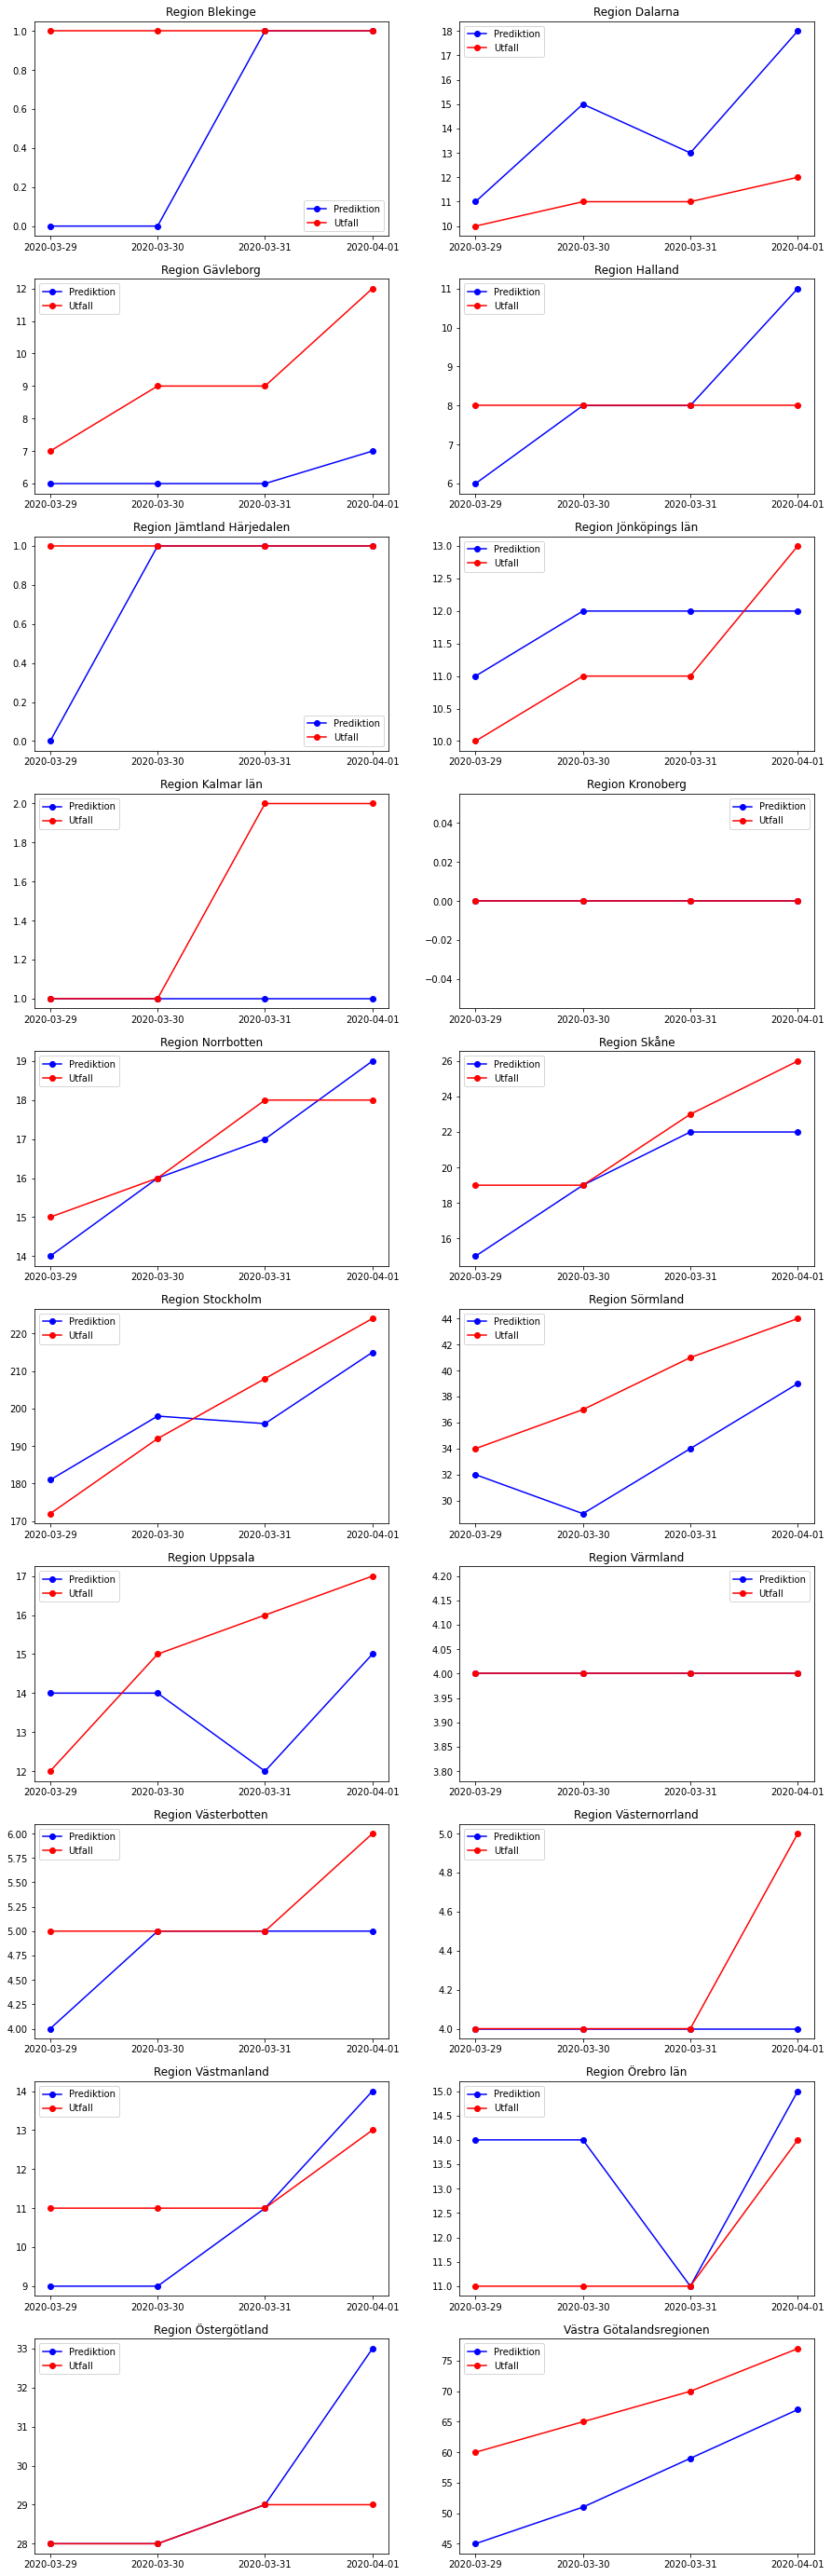

In [412]:

f = plt.figure(figsize=(15,50))

for i in range(20):
    ax = f.add_subplot(10, 2, i+1)
    ax.plot(results[results['Region'] == regioner[i]]['date'], 
            results[results['Region'] == regioner[i]]['predicted'],
            '-ob',
            label='Prediktion'
           )
    ax.plot(results[results['Region'] == regioner[i]]['date'],
            results[results['Region'] == regioner[i]]['iva'],
            '-or',
            label='Utfall'
           )
    ax.set_title(regioner[i])
    ax.legend()

plt.show()



### Feature evaluation

In [413]:
importance = list(model.feature_importances_)
features = X.columns

feature_importance = pd.DataFrame({'feature': features, 'importance': importance})
feature_importance.sort_values('importance', ascending=False)

,feature,importance
11,iva_per_1000,0.727755
10,case_change_from_day_10_to_4,0.061165
3,change_since_1_days,0.039893
1,befolkning,0.037190
0,iva,0.028982
9,change_since_7_days,0.024936
4,change_since_2_days,0.018185
5,change_since_3_days,0.015936
6,change_since_4_days,0.015031
7,change_since_5_days,0.013034


In [406]:
test[test['Region'] == 'Västra Götalandsregionen'][['date', 'iva', 'predicted_change', 'predicted_nbr_in_3_days', 'iva_in_3_days']]

,date,iva,predicted_change,predicted_nbr_in_3_days,iva_in_3_days
20,2020-03-26,40.0,1.131945,45,60.0
21,2020-03-27,44.0,1.166854,51,65.0
22,2020-03-28,49.0,1.206446,59,70.0
23,2020-03-29,60.0,1.131945,67,77.0
